# crvUSD: *Just* what the user needs to know

## Table of contents

- Overview
- Fundamental concepts
- Creating a loan
- Repaying a loan
- Adding collateral
- Monitoring a position
- External liquidation & self-liquidation

This is the "dangerous bend" symbol: <font size="10">&#9761;</font>.  It is used to indicate passages that go deeper and can be safely skipped on a first reading.

## Overview

Curve's new decentralized, collateral-backed stablecoin, crvUSD, refines several known mechanisms and cleverly combines them with a novel liquidation mechanism which offers lower risk at greater capital efficiency.  This mechanism, dubbed "LLAMMA", rebalances collateral via an AMM that pays for immediacy by offering better prices than the market.  These collateral rebalances smoothly swaps collateral for stablecoin to keep the position sufficiently collateralized while recovering the collateral when the collateral price goes back up. 

Like Maker's DAI or Abracadabra's MIM, crvUSD is "minted" by depositing collateral and borrowing against it.  The borrowing rate dynamically changes based on fluctuating supply and demand in order to keep the peg stable.  As an additional stabilization mechanism, the "peg keeper" module is able to mint and burn a limited supply of crvUSD into crvUSD stableswap pools.   

## Fundamental concepts

It is assumed the user has some familiarity already with collateralized debt positions (CDP) but we will briefly review to establish terminology.  Then we will cover the essentials necessary for a user to create and safely manage a position.

While it's not necessary for a user to understand the nitty-gritty of the smart contracts underlying the crvUSD protocol, it is still very helpful for the discussion to have a high-level understanding of separation of responsibilities amongst the primary components.

Controller: the contract the user interacts with to create a loan, repay, and withdraw.  It holds all user debt information.  External liquidations are also done through it.

LLAMMA: the market-making contract that rebalances collateral.  The controller can deposit and withdraw from it.  Arbitrageurs interact with LLAMMA to do the necessary arbitrages.

Peg keeper: can create debt by minting crvUSD into a pool pairing crvUSD with another stablecoin.  There is a separate peg keeper for each such pool.  The minting can only happen when crvUSD is *above* peg.  This debt can then be "paid back" when crvUSD is *below* peg by withdrawing and burning crvUSD from the pool.

### Collateralized debt position

### Liquidation range

When the user takes out a loan (creates a CDP), the controller determines the range where the LLAMMA rebalances the collateral.  Note that until the oracle price enters this range, the collateral is untouched.  Since we often consider the scenario when the oracle price dips down into the range, we call the higher end of the range the "start" and the lower end the "end".

The liquidation range is chosen according to a fixed price grid.  Each pair of consecutive grid points determine a "band".

When creating a CDP, the user specifies the number of bands to deposit collateral into, and the amount of debt to borrow.  The max amount of borrowable debt is determined by number of bands, collateral amount, and the oracle price. 

First, the recoverable value under soft liquidation of the collateral (after discount) is calculated.  This calculation computes for each band the result of swapping the collateral for crvUSD as the oracle price smoothly moves through the band and then totals all the swap results.  The lower the high-end of the range, the less value results.  

The max borrowable amount is thus the value obtained by starting the range "right under" the oracle price.


<br><font size="10">&#9761;</font> "Right under" is in quotes because technically if arbs are lagging so the AMM may not have caught up to the oracle price, then we cannot deposit collateral into the bands in-between the active band and oracle price.  This should be more understandable after reading the section "AMM bands".


#### Price ticks

The range of possible oracle prices is divided up into grid points, or "ticks", controlled by an amplification factor `A`.  There is a "base price" `p_base`, which is multiplied by or divided by a factor depending on `A` to obtain subsequent grid prices.

```python
def p_up(n):
    return ((A-1)/A)**n * p_base

def p_down(n):
    return ((A-1)/A)**(n+1) * p_base
```

Note that as `A` increases, the interval `(p_down(n), p_up(n)` shrinks.  Since an equal portion of your collateral will be deposited in each band, this means that with greater amplification, the AMM is more leveraged in each band.  Like a normal CFMM, this will increase impermanent loss.  With LLAMMA, your market-maker losses will also be increased due to the extra cost of immediacy.

<br><font size="10">&#9761;</font> 

#### AMM bands

Conceptually, the main idea is that LLAMA always skews the prices like a "taker", someone who pays for immediacy of trade execution by "crossing the spread", i.e. buys above the market mid and sells below the market mid.  Of course, a smart contract cannot execute anything without an EOA triggering a transaction, so the way this works in practice is that LLAMA sets the prices like a taker and relies upon arbitrageurs to "arb" the price back to market (oracle price).

It is important to understand that the ticks `(p_down(n), p_up(n))` are not the actual market-maker prices.  The real interval of market-maker prices used by LLAMMA is `(p_cd(p_o, n), p_cu(p_o, n))` and depends on the current oracle price `p_o`.

Each band works like Uniswap V3, concentrating liquidity between two prices, and being all in the collateral at the lower price and all in crvUSD at the higher price.  However since the entire interval of prices are aggressively placed with respect to the market (higher than oracle price when it's moving up and lower when it's moving down), each band gets arbed to hold all of either collateral or stablecoin in the *opposite* manner than expected when LP-ing with Uniswap V3.

The easiest way to understand this is to consider two cases:

1. when the oracle price is within the price ticks of the band
2. when the oracle price is NOT within the price ticks of the band

The first case looks like this:

We have illustrated the neighboring price ticks so that we can see what happens in the neighboring AMM bands as the oracle price moves smoothly into the middle tick range and then smoothly out.

This is the ideal case of "adiabatic" trading, when the AMM price `p` closely follows the oracle price `p_o`.  

However, crucially, each band does not stop "working" when the oracle price is out of range of its ticks.  This can be seen in the next figure where we keep extending each band's AMM prices beyond its tick range.  Note each band stacks on top of each other so that a band with lower tick prices sits above the band with higher tick prices.  This is because each band has a steeper slope than the line given by the oracle price.


Hopefully it should now be much clearer how Uniswap V3-like positions can be stacked to exhibit "opposite" behavior, i.e. as collateral price increases, the LP is holding *more* of the collateral, while as the price decreases, the LP is holding *less* of the collateral.  This is because the prices offered by the AMM incentivize arbs to trade down (sell) as the price moves up and to trade up (buy) as the price moves down.  The opposite would happen on a typical constant function market-maker (CFMM) as the AMM price would lag the market and arbs would trade up as the market moves up and trade down as the market moves down.  Each band thus gets saturated with either collateral or stablecoin, except for the *active* band, which is the band whose ticks contain the oracle price.  Band above the active band will be saturated with stablecoin while those below the active band will be saturated with collateral.


<br><font size="10">&#9761;</font> Since arbs don't happen instantaneously, in reality these can always lag the oracle price, so the active band isn't necessarily the one whose ticks contain the oracle price.  Instead we can just define it by the property that bands above hold either all stablecoin or are empty, while those below hold either all collateral or are empty.  

### Discounts

loan discount

liquidation discount



In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from math import sqrt
import numpy as np
from bisect import bisect_left

In [4]:
# oracle price
p_o = 1700

# collateral grid settings
p_base = 1850
A = 100
N = 10


In [5]:
def p_up(n):
    return ((A-1)/A)**n * p_base

def p_down(n):
    return ((A-1)/A)**(n+1) * p_base

p_up(4), p_up(5)

(1777.1026184999998, 1759.3315923149999)

In [6]:
# p_o * A * y_0**2 - y_0 (p_up * (A - 1) * x / p_o + p_o**2 * A * y / p_up) - x * y = 0

def calc_y_0(p_o, n, x, y):
    a = p_o * A
    b = - (p_up(n) * (A-1) * x / p_o + p_o**2 * A * y / p_up(n))
    c = - x * y

    return (-b + sqrt(b**2 - 4*a*c) ) / (2*a)

calc_y_0(p_o, 0, 1000, 10)

9.828910958786647

In [7]:
def amm_band(p_o, n, x, y):
    p_cd = p_o**3 / p_up(n)**2
    p_cu = p_o**3 / p_down(n)**2
    y_0 = calc_y_0(p_o, n, x, y)
    f = p_o**2 / p_up(n) * A * y_0
    g = p_up(n) * (A-1) / p_o * y_0
    I = p_o * A**2 * y_0**2
    return {
        "p_cd": p_cd,
        "p_cu": p_cu,
        "p": (x + f) / (g + y),
        "y_0": y_0,
        "f": f,
        "g": g,
        "I": I
    }

amm_band(p_o, n=3, x=1200, y = 1)

{'p_cd': 1524.7271715111642,
 'p_cu': 1555.6853091635185,
 'p': 1538.2130301398336,
 'y_0': 1.6891234340636727,
 'f': 271945.52564886527,
 'g': 176.573275155545,
 'I': 48503345.58355193}

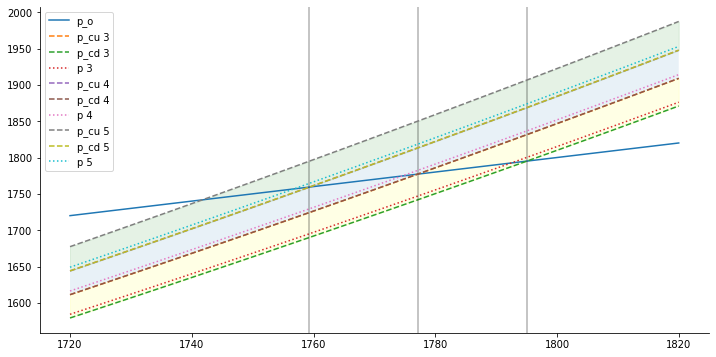

In [8]:
f, ax = plt.subplots(figsize=(12,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


x = 2400  # stable
y = 8  # collateral

prices = np.linspace(1720, 1820, 100)

ax.plot(prices, prices, label="p_o")


n = 3
amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]  # same as p_cu for n-1
amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]
ax.axvline(p_up(n), color='black', alpha=0.3)

ax.plot(prices, amm_up_prices, '--', label="p_cu 3")
ax.plot(prices, amm_down_prices, '--', label="p_cd 3")
ax.plot(prices, amm_center_prices, ':', label="p 3")
ax.fill_between(prices, amm_down_prices, amm_up_prices, color='yellow', alpha=0.1)

n = 4
amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]
amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]
ax.axvline(p_up(n), color='black', alpha=0.3)

ax.plot(prices, amm_up_prices, '--', label="p_cu 4")
ax.plot(prices, amm_down_prices, '--', label="p_cd 4")
ax.plot(prices, amm_center_prices, ':', label="p 4")
ax.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)

n = 5
amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]  # same as p_cu for n-1
amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]
ax.axvline(p_up(n), color='black', alpha=0.3)

ax.plot(prices, amm_up_prices, '--', label="p_cu 5")
ax.plot(prices, amm_down_prices, '--', label="p_cd 5")
ax.plot(prices, amm_center_prices, ':', label="p 5")
ax.fill_between(prices, amm_down_prices, amm_up_prices, color='green', alpha=0.1)


ax.legend()

Text(0.5, 0, 'Oracle Price')

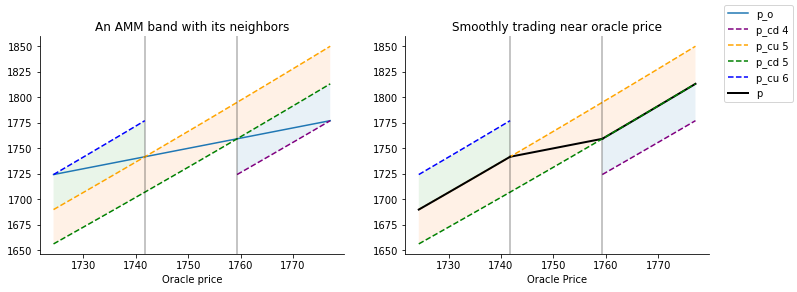

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
ax, ax2 = axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

x = 1200  # stable
y = 1  # collateral

prices = np.linspace(p_down(6), p_up(4), 100)

ax.plot(prices, prices, label="p_o")


n = 4
prices = np.linspace(p_down(n), p_up(n), 100)


amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]
amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]

ax.plot(prices, amm_down_prices, '--', color='purple', label=f"p_cd {n}")
ax.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)

ax2.plot(prices, amm_up_prices, color='black', linewidth='2')
ax2.plot(prices, amm_down_prices, '--', color='purple')
ax2.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)

n = 5
prices = np.linspace(p_down(6), p_up(4), 100)

amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]
amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]

ax.plot(prices, amm_up_prices, '--', color='orange', label=f"p_cu {n}")
ax.plot(prices, amm_down_prices, '--', color='green', label=f"p_cd {n}")
ax.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)

ax.axvline(p_up(5), color='black', alpha=0.3)
ax.axvline(p_down(5), color='black', alpha=0.3)

middle_band_prices = np.linspace(p_down(5), p_up(5), 100)
ax2.plot(middle_band_prices, middle_band_prices, color='black', linewidth='2', label="p")

ax2.plot(prices, amm_up_prices, '--', color='orange')
ax2.plot(prices, amm_down_prices, '--', color='green')
ax2.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)

ax2.axvline(p_up(5), color='black', alpha=0.3)
ax2.axvline(p_down(5), color='black', alpha=0.3)


n = 6
prices = np.linspace(p_down(n), p_up(n), 100)

amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]
amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]

ax.plot(prices, amm_up_prices, '--', color='blue', label=f"p_cu {n}")
ax.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)

ax2.plot(prices, amm_up_prices, '--', color='blue')
ax2.plot(prices, amm_down_prices, color='black', linewidth='2')

ax2.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)

fig.legend()

ax.title.set_text("An AMM band with its neighbors")
ax2.title.set_text("Smoothly trading near oracle price")

ax.set_xlabel("Oracle price")
ax2.set_xlabel("Oracle Price")

## Setting the collateral bands for collateral and debt amounts


Average swap price (adiabatic trading in band `n`:

`sqrt(p_up(n) * p_down(n)) == p_up(n) * sqrt((A-1)/A)`


Handy formula for calculating "effective" liquidation amount (result from soft liquidation):

```
x_effective = (y/N) * [ p_up(n) * sqrt(A-1)/A + (A-1)/A * p_up(n) * sqrt(A-1)/A 
    + ((A-1)/A)**2 * p_up(n) * sqrt(A-1)/A + ... + ((A-1)/A)**(N-1) * p_up(n) * sqrt(A-1)/A ]
    = (y/N) * sqrt((A-1)/A) * p_up(n) * [ 1 + ((A-1)/A) + ((A-1)/A)**2 + ... + ((A-1)/A)**(N-1) ]
    = y_effective * p_up(n)
```

As `n` increases, `y_effective * p_up(n)` will decrease.  When creating a loan, we calculate the maximal `n` such that  `y_effective * p_up(n)` is still more than the desired debt amount.  This is how the collateral range is determined.

## Comparing soft liquidation to hard liquidation

In [57]:
def p_current_mid(p_o, n):
    return p_o**3 / (p_down(n) * p_up(n))

def get_x_down(p_o):
    """
    Calculate amount gained from arbs swapping through all AMM bands priced below p_o
    assuming p_o is dropping so that each band has only collateral to start with
    """
    x_equiv = 0
    for n in range(N):
        if p_o < p_down(n): # need to sell all the collateral
            x_equiv += (y/N) * p_current_mid(p_o, n)
        elif p_o > p_up(n): # we assume bands only have collateral so no need to buy
            continue
        else: # p_o is within the band
            # calculate quantities after trading to p_o: x_o, y_o
            # p_o = (f + x_o) / (g + y_o) 
            # p_o * (g + y_o)**2 = I or (f + x_o)**2 / p_o = I
            band = amm_band(p_o, n, x=0, y=y/N)
            f = band["f"]
            g = band["g"]
            I = band["I"]
            x_o = sqrt(I * p_o) - f
            y_o = sqrt(I / p_o) - g
            x_equiv += x_o
            x_equiv += sqrt(p_o * p_down(n)) * y_o  # start swap of y_o at price p_down, ending at p_o
    return x_equiv

get_x_down(p_o)

35382.086700161184

Value at start of liquidation: 46250.0
Hard vs soft liquidation loss: 0.02219851742120227
Hard vs soft liquidation loss: 71.00866946763199
Hard vs soft liquidation loss: 272.4258763137004
Hard vs soft liquidation loss: 610.8199749170344
Hard vs soft liquidation loss: 1061.6172527631024
Hard vs soft liquidation loss: 1634.1352476713728
Hard vs soft liquidation loss: 2327.1597589581143
Hard vs soft liquidation loss: 3122.0732947144643
Hard vs soft liquidation loss: 4030.4124812816954
Hard vs soft liquidation loss: 5029.094835740732


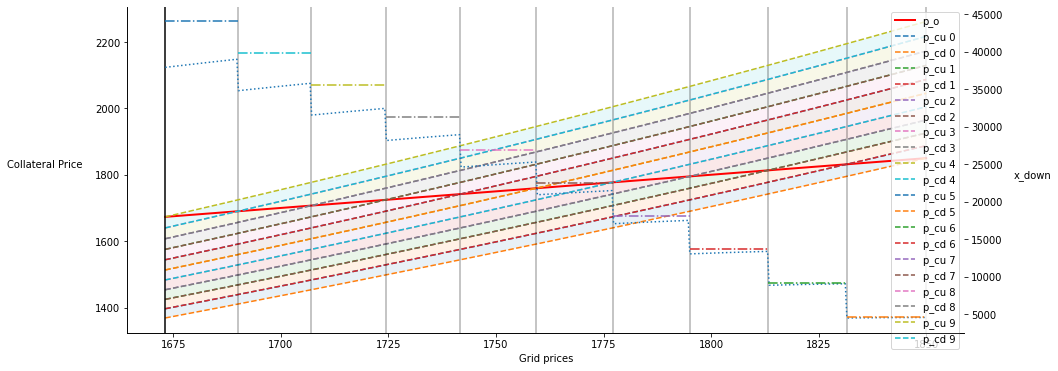

In [59]:
f, ax = plt.subplots(figsize=(15,6))
ax.set_ylabel("Collateral Price", rotation=0, labelpad=50)
ax.set_xlabel("Grid prices")
ax2 = ax.twinx()
ax2.set_ylabel("x_down", rotation=0, labelpad=30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

x = 0  # stable
y = 25  # collateral

print("Value at start of liquidation:", y * p_up(0))

prices = np.linspace(p_up(N), p_up(0), 500)

ax.plot(prices, prices, label="p_o", linewidth=2, color='r')

x_downs = [get_x_down(p) for p in prices]
ax2.plot(prices, x_downs, ':', label="x_down")

x_effective = 0

for n in range(N):
    ax.axvline(p_up(n), color='black', alpha=0.3)
    amm_up_prices = [amm_band(p, n, x, y)["p_cu"] for p in prices]
    amm_down_prices = [amm_band(p, n, x, y)["p_cd"] for p in prices]  # same as p_cu for n-1
    amm_center_prices = [amm_band(p, n, x, y)["p"] for p in prices]

    ax.plot(prices, amm_up_prices, '--', label=f"p_cu {n}")
    ax.plot(prices, amm_down_prices, '--', label=f"p_cd {n}")
    # ax.plot(prices, amm_center_prices, ':', label=f"p {n}")
    ax.fill_between(prices, amm_down_prices, amm_up_prices, alpha=0.1)
    
    # x += y/N * sqrt(p_up(n) * p_down(n))
    x_effective += y/N * p_up(n) * sqrt((A-1)/A)
    ax2.plot(np.linspace(p_down(n), p_up(n), 25), [x_effective]* 25, '-.')
    
    i = bisect_left(list(prices), p_up(n))
    print("Hard vs soft liquidation loss:", x_effective - x_downs[i-1])
    
ax.axvline(p_up(N), color='black')

ax.legend()